In [2218]:
import pandas as pd
import warnings
from sodapy import Socrata
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt


MTA_client = Socrata("data.ny.gov", None)

ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests': '7tfn-twae',
    'subway fare evasion': '6kj3-ijvb',
    'bus fare evasion': 'uv5h-dfhp',
    'headcount 2024': 'ui26-n8p4'
}

In [2480]:
def get_dataset(ds_name: str, begin: str=None, before: str=None, MTA_client=None) -> pd.DataFrame:
    """
    retrieves a pandas dataframe from a corresponding MTA data source
    filters for optional start and end times; careful not passing any start or end times - over 100 million rows for hourly data
    assumes the existence of MTA_client
    """
    sample = MTA_client.get(ds_dictionary[ds_name], limit=1)
    time_columns = [v for v in sample[0].keys() if v.lower().endswith(('date', 'timestamp', 'month', 'time_period'))]
    if MTA_client is None: raise Exception('MTA_client not found; required for connection to data repository')
    
    if len(time_columns) == 0:
        warnings.warn(f'No time column found: {sample[0].keys}')
        try:
            res_dict = MTA_client.get_all(ds_dictionary[ds_name])
            return pd.DataFrame.from_records(res_dict)
        except Exception as e:
            raise Exception(f"Couldn't get all rows. Too many? {e}")

    if len(time_columns) > 1:
        raise Exception(f'Too many time columns found: {sample.keys}')

    where_string = ''
    time_column = time_columns[0]
    if begin and not before: where_string = f"{time_column} >= '{begin}'"
    if not begin and before: where_string = f"{time_column} < '{before}'"
    if begin and before: where_string = f"{time_column} >= '{begin}' AND {time_column} < '{before}'"
    res_dict = MTA_client.get_all(ds_dictionary[ds_name], where=where_string, order=f'{time_column} ASC')
    return pd.DataFrame.from_records(res_dict)


def rid_irrelevant_criteria(df: pd.DataFrame, kept: dict) -> pd.DataFrame:
    """
    for a given pandas dataframe, drop column values that match a list of kept values
    ie., kept: {'metrics': 'Arrests'} -> all rows w/o 'Arrests' for 'metrics' column are dropped
    """
    keys = set(kept.keys())
    if keys.intersection(set(df.columns)) != keys:
        raise Exception(f'Kept columns not found in dataframe: {keys.intersection(set(df.columns))}')
    for key in keys:
        if set(df[key].unique()).intersection(kept[key]) != kept[key]:
            raise Exception(f'At least one kept value from column {key} DNE: {kept[key]}') 
    
    for key in keys: 
        df = df.where(df[key].isin(kept[key])).dropna().reset_index(drop=True)
    return df


def aggregate_by_timeframe(df: pd.DataFrame, timeframe: str, typ: str) -> pd.DataFrame:
    """
    aggregates a timeframe by timeframe; results are summed or averaged
    """
    if timeframe not in ['hourly', 'daily', 'weekly', 'monthly']:
        raise Exception(f'Invalid timeframe {timeframe}')
    if typ not in ['mean', 'sum']:
        raise Exception(f'Invalid type {typ}')
    
    time_columns = [v for v in df.columns if v.lower().endswith(('date', 'timestamp', 'month', 'time_period'))]
    if len(time_columns) != 1:
        raise Exception(f'Zero or more than one time column(s) found: {df.columns}')

    time_column = time_columns[0]
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    for column in df.columns:
        if column != time_column:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')
            except TypeError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')

    df = df.set_index(time_column)
    timeframe_dictionary = {'hourly': 'h', 'daily': 'd', 'weekly': 'W', 'monthly': 'ME'}

    if typ == 'mean': return df.resample(timeframe_dictionary[timeframe]).mean(numeric_only=True).reset_index() 
    if typ == 'sum': return df.resample(timeframe_dictionary[timeframe]).sum(numeric_only=True).reset_index() 


def rolling_average(values, window_size):
    values = np.array(values, dtype=float)
    rolling_avg = np.full(len(values), np.nan)

    for i in range(len(values)):
        window = values[max(0, i - window_size + 1):i + 1]
        valid_values = window[~np.isnan(window)]
    
        if len(valid_values) > 0:
            rolling_avg[i] = np.mean(valid_values)

    return rolling_avg


In [2819]:
# df_crimes = get_dataset('summonses and arrests', begin='2024-01-01', before='2024-11-01', MTA_client=MTA_client)
# df_crimes = rid_irrelevant_criteria(df_crimes,
#         {'metric': {
#             'Fare Evasion Arrests',
#             'Fare Evasion Criminal Summons',
#             'Fare Evasion TABS Summons',
#             'Fare Evasion Summons'}})
# df_crimes_agg = aggregate_by_timeframe(df_crimes, 'monthly', 'sum')
# plt.plot(df_crimes_agg.month, df_crimes_agg.total)
# plt.axvline(datetime.strptime('2024-08-14', '%Y-%m-%d'), color='red')

In [2821]:
# df_ridership = get_dataset('ridership', begin='2020-06-01', before='2024-11-01', MTA_client=MTA_client)

# # df_ridership = aggregate_by_timeframe(df_ridership, 'monthly', 'mean')

# df_ridership['date'] = pd.to_datetime(df_ridership['date'])
# df_ridership['subways_total_estimated_ridership'] = df_ridership['subways_total_estimated_ridership'].astype(float) 
# plt.plot(df_ridership.date, df_ridership.subways_total_estimated_ridership	)
# plt.axvline(datetime.strptime('2024-08-14', '%Y-%m-%d'), color='red')

C:\Users\zclle\AppData\Local\Temp\ipykernel_17020\1877720799.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sfe['time_period'] = pd.to_datetime(df_sfe['time_period'])


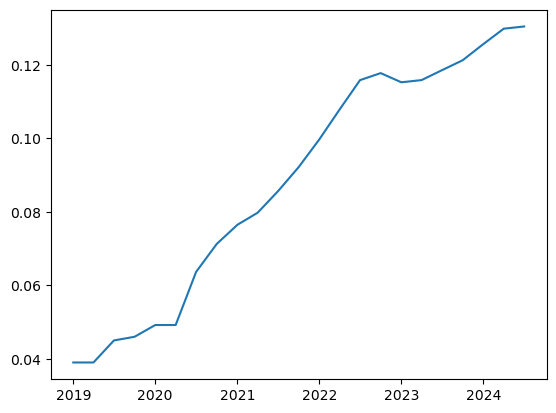

In [2788]:
df_sfe = get_dataset('subway fare evasion', begin='2019-01-01', MTA_client=MTA_client)
df_sfe['fare_evasion'] = rolling_average(df_sfe['fare_evasion'], 10)
df_sfe['time_period'] = pd.to_datetime(df_sfe['time_period'])
plt.plot(df_sfe.time_period, df_sfe.fare_evasion.astype(float))

C:\Users\zclle\AppData\Local\Temp\ipykernel_17020\3591793856.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_bfe['time_period'] = pd.to_datetime(df_bfe['time_period'])


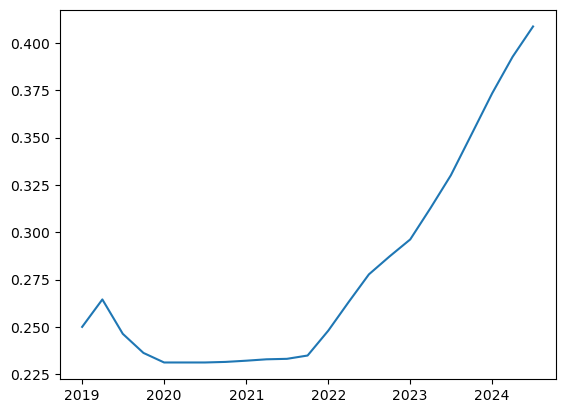

In [2790]:
df_bfe = get_dataset('bus fare evasion', begin='2019-01-01', MTA_client=MTA_client)
df_bfe['ridership']= df_bfe['ridership'].astype(float)
df_bfe['fare_evasion'] = df_bfe['fare_evasion'].astype(float)
df_bfe['time_period'] = pd.to_datetime(df_bfe['time_period'])

# df_bfe = df_bfe.groupby('time_period', as_index=False)[['fare_evasion', 'ridership']].mean()
df_bfe = df_bfe[df_bfe.trip_type == 'Local']

df_bfe['fare_evasion'] = rolling_average(df_bfe['fare_evasion'], 10)
plt.plot(df_bfe.time_period, df_bfe.fare_evasion.astype(float))

[45.86226205 -6.46591046  0.44253581]
R^2: 0.953335444601242
RMSE 0.014892091357563093


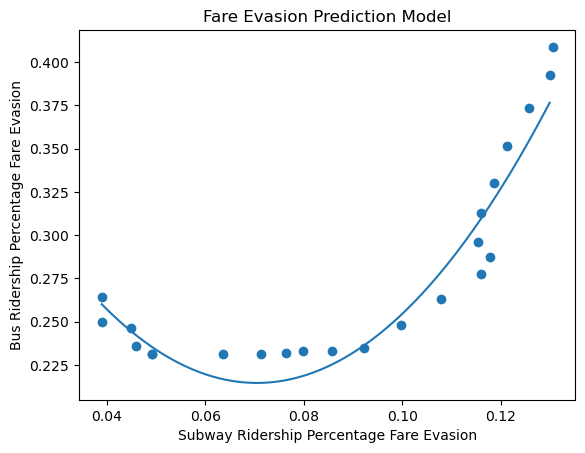

In [2715]:
def polyfit(x, y, p=2):

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=13542009)
    
    model = np.poly1d(np.polyfit(X_train, Y_train, 2))
    line = np.linspace(X_train.min(), X_train.max(), 100)

    Y_pred_train = model(X_train)
    Y_pred_test = model(X_test)
    
    plt.scatter(x, y)
    plt.xlabel('Subway Ridership Percentage Fare Evasion')
    plt.ylabel('Bus Ridership Percentage Fare Evasion')
    plt.title('Fare Evasion Prediction Model')

    plt.plot(line, model(line))

    print(np.polyfit(X_train, Y_train, 2))
    
    r2 = r2_score(Y_test, Y_pred_test)
    print('R^2:', r2)
    print('RMSE', np.sqrt(np.mean((Y_test - Y_pred_test) ** 2)))


polyfit(df_sfe.fare_evasion, df_bfe.fare_evasion)

In [2827]:
# temp_1 = aggregate_by_timeframe(df_bfe, 'monthly', 'mean')
# df_0 = rolling_average(temp_1.fare_evasion, 10)
# plt.plot(temp_1.time_period, df_0)

# temp = aggregate_by_timeframe(df_sfe, 'monthly', 'mean')
# df_1 =  rolling_average(temp.fare_evasion, 10)
# plt.plot(temp.time_period, df_1)

# polyfit(df_1, df_0)

In [1678]:
import requests
from bs4 import BeautifulSoup
import newspaper
from tqdm import tqdm


def get_articles_by_query(query: str, start: str, end: str, page: int=0):
    """
    gets all relevant news articles by query (google search), returns articles between start and end dates 'YYYY-MM-DD'
    recalls itself if search results == 10: an indication that there are more results next page
    
    ***WARNING: DO NOT CALL UNNECESSARILY - GOOGLE MAY IP-BAN BOT ACTIVITY; BE MINDFUL OF FREQUENT USE***

    """
    url = f'https://www.google.com/search?q={'+'.join(query.split())}+after:{start}+before:{end}+&tbm=nws&start={page * 10}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = []
    
    for link in soup.find_all('a'):
        weblink = str(link['href'])
        if weblink[:15] == '/url?q=https://' and '.google.com' not in weblink:
            articles.append(weblink[7:].split('&')[0])

    if len(articles) == 0:
        return []
    articles.extend(get_articles_by_query(query, start, end, page + 1))
    return articles


def get_articles_df(articles, drop_unfound_published_timestamp=True):
    """
    converts a list of articles into a pandas DataFrame through newspaper3k
    some articles (~10%) cannot be parsed for unknown reason, TODO
    some articles (~30%) could be parsed but their published_date cannot be automatically collected
    """
    ret_dict = {'title': [],  'timestamp': [], 'text': [], 'link': []}
    for index in tqdm(range(len(articles))):
        try:
            article = newspaper.Article(articles[index])
            article.download()
            article.parse()
            article.nlp()

            if article.title == 'Are you a robot?': continue
            
            ret_dict['title'].append(article.title)
            ret_dict['timestamp'].append(article.publish_date)
            ret_dict['text'].append(article.summary)
            ret_dict['link'].append(articles[index])
        
        except Exception as e:
            pass

    df = pd.DataFrame(ret_dict)
    df.drop_duplicates(inplace=True)
    if drop_unfound_published_timestamp:
        df = df.dropna().reset_index(drop=True)
    return df
    

In [1874]:
import time

start = time.time()

articles = get_articles_by_query('MTA COVID', start='2018-01-01', end='2024-12-01')

print(time.time() - start)

27.45174741744995


In [1875]:
df = get_articles_df(articles)
len(df)

100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [03:35<00:00,  1.12it/s]


184

In [2767]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd 
import sqlite3
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.power import TTestPower, TTestIndPower, FTestAnovaPower, GofChisquarePower


def func_8(a, b):
    a = np.array(a).reshape(-1, 1)
    b = np.array(b).reshape(-1, 1)
    X_train, X_test, Y_train, Y_test = train_test_split(a, b, test_size=0.2, random_state=13542009)
    
    linreg = LinearRegression()
    linreg.fit(X_train, Y_train)
    
    Y_pred_train = linreg.predict(X_train)
    Y_pred_test = linreg.predict(X_test)

    print('Coefficients:', linreg.coef_[0])
    print('Intercept:', linreg.intercept_)

    plt.scatter(X_test, Y_test)
    
    def abline(slope, intercept):
        x_vals = np.array((X_test.min(), X_test.max()))
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')

    abline(linreg.coef_[0], linreg.intercept_)
        
    r2 = r2_score(Y_test, Y_pred_test)
    print('R^2:', r2)
    print('RMSE', np.sqrt(np.mean((Y_test - Y_pred_test) ** 2)))
    

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


def func(df_main, df, typ=''):
    a, b = [], []
    d_col, v_col = df_main.columns[:2]
    for ind in range(len(df)):
        r = df_main[df_main[d_col] == datetime(*tuple(df.iloc[ind].timestamp.timetuple())[:3])]
        if r.empty:
            
            continue
        a.append(r[v_col].values[0])
        b.append(df.iloc[ind][typ])
    return a, b


def func_1(a, b):

    c, d = [], []
    for ind in range(len(a)):
        if b[ind] == 0:
            c.append(a[ind])
        else:
            d.append(a[ind])
    
    plt.hist(c, bins=20, alpha=0.6, color='red', label='Group 1')
    plt.hist(d, bins=20, alpha=0.6, color='blue', label='Group 2')
    plt.legend()

    print(stats.mannwhitneyu(c, d, alternative='two-sided'))
    # print('Statistical power is', calculate_power('mwu', [males, females], alpha=0.005))

In [1878]:
# df['text'] = df['text'].apply(preprocess_text)


analyzer = SentimentIntensityAnalyzer()


def get_pos_sentiment(text):
    return analyzer.polarity_scores(text)['pos']
    
def get_neg_sentiment(text):
    return analyzer.polarity_scores(text)['neg']


df['pos'] = (df['text']).apply(get_pos_sentiment)
df['neg'] = (df['text']).apply(get_neg_sentiment)

In [1881]:
df['SENTIMENT'] = ((df.pos > df.neg) & ((df.neg != 0) & (df.pos != 0))).astype(int)

Coefficients: [924126.14989811]
Intercept: [2158959.03409973]
R^2: -0.045741147377835745
RMSE 884166.6233550019


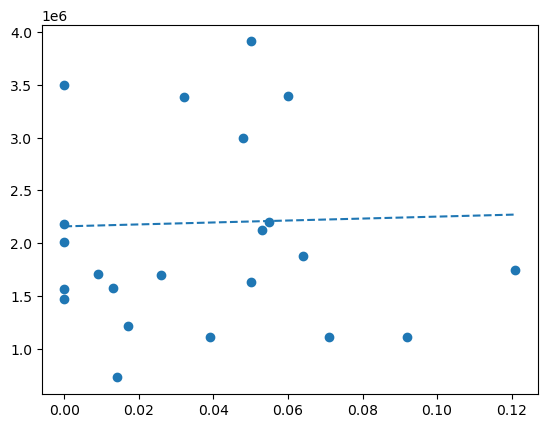

In [2817]:
a, b = func(df_ridership, df, 'pos')
func_8(b, a)

Coefficients: [2220814.29486394]
Intercept: [2106035.83184262]
R^2: -0.1157078727666685
RMSE 913265.9524641907


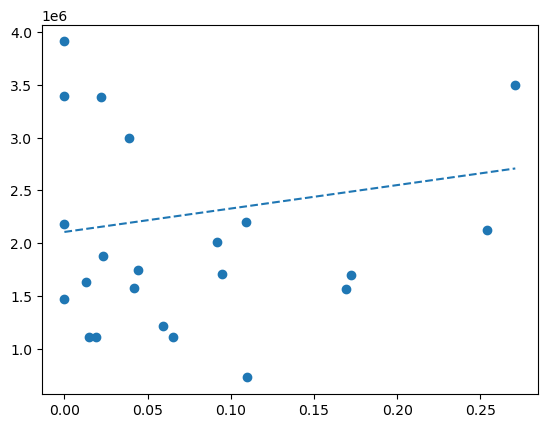

In [2778]:
a, b = func(df_ridership, df, 'neg')
func_8(b, a)

Coefficients: [-32437.96153846]
Intercept: [2231583.21153846]
R^2: -0.058249425225568974
RMSE 889438.7345807718


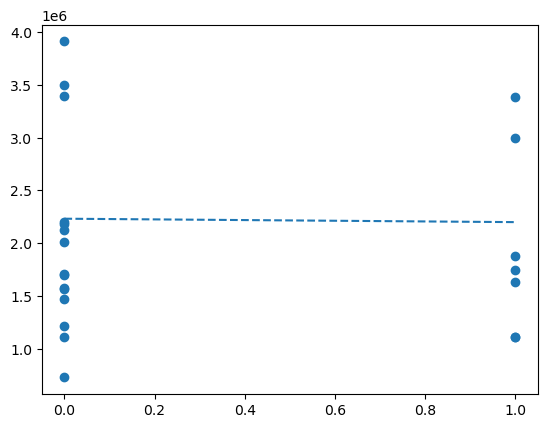

In [2780]:
a, b = func(df_ridership, df, 'SENTIMENT')
func_8(b, a)

MannwhitneyuResult(statistic=1476.5, pvalue=0.8278362721084616)


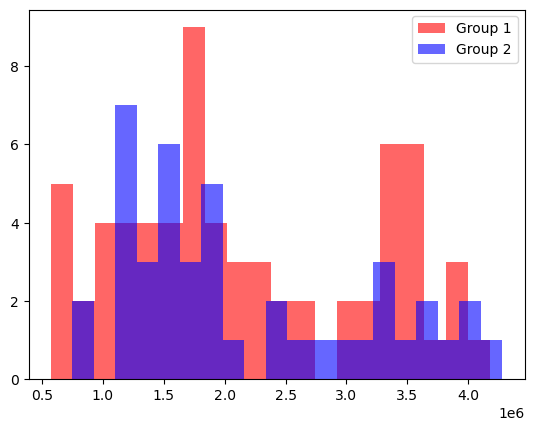

In [2782]:
func_1(a, b)